# Data Manipulation

Data manipulation: 
    1. remove duplicate rows
    2. add last day's volume, open interest rate, closing price for each option 
    3. add last week's volume, open interest rate, closing price for each option
    4. add last day's sp500 price and last week's price 
    5. select options whose today's sp500 price is within 30 of strike price 
    5. remove rows with null values
    6. group all the options corresponding to their (settlement date, today's date) and pick all the interested features

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [2]:
def readToDataFrame(input):
    """ read data from input path 
        drop duplicates
        and return dataframe where settle date and todaydate is transfferd to datetime format
    """
    optiondata = pd.read_table( input, delimiter = ",")
    todaydate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.todaydate]
    optiondata.todaydate = todaydate_tmp
    settledate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.settledate]
    optiondata.settledate = settledate_tmp
    return optiondata.drop_duplicates()
optiondata = readToDataFrame("relevantoptions2")

In [3]:
# create dictionary to store everyday's sp500 price

def createPriceDict(row, pricedict):
    if not pricedict.has_key(row['todaydate'].strftime("%B %d, %Y")):
        pricedict[row['todaydate'].strftime("%B %d, %Y")] = row['today_sp_price']

def getPrice(df):
    """get vol and sp500 today price for each day
    """
    price = {}
    df.apply(lambda row: createPriceDict(row, price), axis=1)
    return price

priceDict = getPrice(optiondata)

In [4]:
# create dictionary to store every option's volume, open interest rate, closing price for each day 
# option can be identified by settledate, optiontype, option strike
def createOptionDict(row, optdict):
    if not optdict.has_key((row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])):
        optdict[(row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])] = (row['optionvol'],
                    row['optionopenint'], row['optionclosingprice'])
        
def getOption(df):
    """get vol and sp500 today price for each day 
    """
    optionDic = {}
    df.apply(lambda row: createOptionDict(row, optionDic), axis=1)
    
    return optionDic

optionDic = getOption(optiondata)

In [5]:
#add sp500 yesterday's and last week's price 
def prevPrice1d(row, priceDic):
    i = 1;
    while (i < 5):
        if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
            return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
        else:
            i+=1
    return 0

def prevPrice1week(row, priceDic):
    i = 7;
    if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
        return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
    return 0


def addPrevPrice(df, priceDic):
    """ add s&p price of previous n days to dataframe
    """
    prvPrice =  df.apply(lambda row: prevPrice1d(row, priceDic), axis=1)
    df['sp1d'] = prvPrice
    prvweekPrice =  df.apply(lambda row: prevPrice1week(row, priceDic), axis=1)
    df['sp1w'] = prvweekPrice

addPrevPrice(optiondata,priceDict)

In [6]:
# add option's yesterday and last week's vol, openint and closing price 

def prevOption1d(row, optionDic):
    i = 1;
    while (i < 5):
        if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
            return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
        else:
            i += 1
    return -1

def prevOption1w(row, optionDic):
    i = 7;
    if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
        return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
    return -1


def addOptionDay(df, optionDic):
    # add option volume of previous n days to dataframe
    prevoptionday = df.apply(lambda row: prevOption1d(row, optionDic), axis=1)
    #print prevoptionday.head(20)
    df['volopenint%closing1d'] = prevoptionday
    prevoptionweek = df.apply(lambda row: prevOption1w(row, optionDic), axis=1)
    df['volopenint%closing1w'] = prevoptionweek
    

addOptionDay(optiondata, optionDic)
optiondata.to_csv("optiondata1", index=False)

### some analysis

In [7]:
# select options that whose today's 500 price is within 30 of strike price 
within30data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=30]
within100data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=100]
print within100data.describe()
print within30data.describe()
print optiondata.describe()
haslastweek = within30data[within30data['volopenint%closing1w'] == -1]
haslastweek.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  49326.000000    49326.000000     49326.000000  49326.000000   
mean       8.832624     2048.368944      2055.513247   2042.725236   
std        5.161392      129.590808       130.827040    138.163898   
min        2.000000     1630.480000      1632.970000   1535.000000   
25%        4.000000     1978.090000      1975.890000   1970.000000   
50%        8.000000     2075.000000      2076.620000   2050.000000   
75%       14.000000     2116.100000      2126.060000   2130.000000   
max       19.000000     2369.750000      2381.920000   2455.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        49326.000000     49326.000000    49326.000000  49326.000000   
mean            14.115352        14.548255       13.563686   1925.228622   
std             20.121832        20.567776       19.661600   3528.343207   
min              0.025000         0.000000        0.000000      0

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,sp1w
count,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000,10367.000000
mean,10.661136,2036.095647,2043.120257,2035.815569,16.169118,16.605725,15.551596,2031.117199,11711.120768,2017.912557,1846.085795
std,5.528403,137.399456,139.579961,138.348501,11.588848,11.934190,11.362159,3387.097448,13452.212656,228.833444,601.251687
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,0.000000,0.000000,0.000000,5001.000000,0.000000,0.000000
25%,4.000000,1951.360000,1961.050000,1950.000000,6.750000,7.000000,6.300000,0.000000,6046.000000,1949.150000,1900.530000
50%,11.000000,2063.110000,2067.560000,2060.000000,13.900000,14.300000,13.300000,627.000000,7637.000000,2061.020000,2045.970000
75%,16.000000,2109.840000,2116.100000,2120.000000,23.450000,24.100000,22.700000,2726.000000,11115.500000,2109.600000,2107.960000
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,91.200000,83.200000,62304.000000,165591.000000,2369.750000,2365.380000


Summary

At first, we have 55139 rows;

There are 49326 options whose price is within 100 of strikeprice;

18479 options whose price is within 30 of strikeprice;

Out of 18479 options, 10367 of them don't exist exactly one week before

In [8]:
# add closing price, vol and open interest of  yesterday 
def closing1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionclosingprice']
    else:
        return row['volopenint%closing1d'][2]

def addClosing1d(df):
    """ yesterday's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1day(row), axis=1)
    df['closing1day'] = prvPrice
    
def vol1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionvol']
    else:
        return row['volopenint%closing1d'][0]

def addvol1d(df):
    """ yesterday's volume
    """
    prvVol =  df.apply(lambda row: vol1day(row), axis=1)
    df['vol1day'] = prvVol
    #df['prevPrice1d'].hist()
    
def opint1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionopenint']
    else:
        return row['volopenint%closing1d'][1]

def addopint1d(df):
    """ yesterday's volume
    """
    
    prvopen =  df.apply(lambda row: opint1day(row), axis=1)
    df['opint1day'] = prvopen
    #df['prevPrice1d'].hist()

def addYesterdayData(df):
    addClosing1d(df)
    addvol1d(df)
    addopint1d(df)

addYesterdayData(within30data)


/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [9]:
# add closing price, vol and open interest of  lastweek
def closing1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['closing1day']
    else:
        return row['volopenint%closing1w'][2]

def addClosing1w(df):
    """ last week's closing price
    """
    prvPrice =  df.apply(lambda row: closing1w(row), axis=1)
    df['closing1w'] = prvPrice
    
def vol1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['vol1day']
    else:
        return row['volopenint%closing1w'][0]

def addvol1w(df):
    """ last week's volume
    """
    prvVol =  df.apply(lambda row: vol1w(row), axis=1)
    df['vol1w'] = prvVol
    
def opint1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['opint1day']
    else:
        return row['volopenint%closing1w'][1]

def addopint1w(df):
    """ yesterday's open interest
    """
    prvopen =  df.apply(lambda row: opint1w(row), axis=1)
    df['opint1w'] = prvopen

def addLastWeekData(df):
    addClosing1w(df)
    addvol1w(df)
    addopint1w(df)

addLastWeekData(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [10]:
print within30data.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  18479.000000    18479.000000     18479.000000  18479.000000   
mean       8.697819     2046.839030      2052.967210   2046.591536   
std        5.140933      131.784089       133.459303    132.671996   
min        2.000000     1630.480000      1632.970000   1610.000000   
25%        4.000000     1973.280000      1970.890000   1970.000000   
50%        8.000000     2071.920000      2075.370000   2070.000000   
75%       14.000000     2115.480000      2122.730000   2125.000000   
max       19.000000     2369.750000      2381.920000   2395.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        18479.000000     18479.000000    18479.000000  18479.000000   
mean            15.118914        15.593920       14.492343   2399.733806   
std             11.043623        11.376337       10.802911   4025.838160   
min              0.075000         0.000000        0.000000      0

we found that distribution of top 25% vol are 0 which means they may not be stable. So we ignore features related to vol

In [11]:
#add ratios for closing price and openinterest: today price/ yesterday price and today price/ last week's price
# if the option doesn't exist one week before, the ratio will be the same as today price/ yesterday's price

def closing1dayratio(row):
    return row['optionclosingprice']/row['closing1day']

def addClosing1dratio(df):
    prvPrice =  df.apply(lambda row: closing1dayratio(row), axis=1)
    df['closing1dayratio'] = prvPrice
    
    
def opint1dayratio(row):
    return float(row['optionopenint'])/row['opint1day']

def addopint1dratio(df):
    prvopen =  df.apply(lambda row: opint1dayratio(row), axis=1)
    df['opint1dayratio'] = prvopen
    #df['prevPrice1d'].hist()

def closing1wratio(row):
    return row['optionclosingprice']/row['closing1w']

def addClosing1wratio(df):
    """ last week's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1wratio(row), axis=1)
    df['closing1wratio'] = prvPrice
    
def opint1wratio(row):
     return float(row['optionopenint'])/row['opint1w']

def addopint1w(df): 
    prvopen =  df.apply(lambda row: opint1wratio(row), axis=1)
    df['opint1wratio'] = prvopen
    

def addRatio(df):
    addopint1w(df)
    addClosing1wratio(df)
    addopint1dratio(df)
    addClosing1dratio(df)
    
addRatio(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [12]:
##check whether result is right 
print within30data.count()
print within30data[within30data['closing1wratio']==within30data['closing1dayratio']].count()
# this is consistent with  " And there are 10367 of them that doesn't exist exactly one week before"

todaydate               18479
settledate              18479
daystosettle            18479
today_sp_price          18479
settle_sp_price         18479
optiontype              18479
optionstrike            18479
optionclosingprice      18479
optionhighprice         18479
optionlowprice          18479
optionvol               18479
optionopenint           18479
sp1d                    18479
sp1w                    18479
volopenint%closing1d    18479
volopenint%closing1w    18479
closing1day             18479
vol1day                 18479
opint1day               18479
closing1w               18479
vol1w                   18479
opint1w                 18479
opint1wratio            18479
closing1wratio          18479
opint1dayratio          18479
closing1dayratio        18479
dtype: int64
todaydate               10384
settledate              10384
daystosettle            10384
today_sp_price          10384
settle_sp_price         10384
optiontype              10384
optionstrike            103

In [13]:
#remove unrelated columns 
cleandata = within30data.drop(['optionhighprice','optionlowprice','optionvol','volopenint%closing1d',
                               'volopenint%closing1w','closing1day','vol1day','opint1day','closing1w',
                               'vol1w','opint1w'], axis=1)
cleandata = cleandata[cleandata['sp1d']!=0]
cleandata = cleandata[cleandata['sp1w']!=0]
cleandata.describe()



,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio
count,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000,17434.000000
mean,8.696742,2047.259269,2053.535438,2046.984341,15.031782,14018.103763,2045.816456,2041.663059,1.137764,1.250372,1.045698,1.121430
std,5.151631,130.492077,131.802410,131.418518,11.018523,15213.435295,130.442300,130.915823,0.311842,1.559023,0.147330,0.751647
min,2.000000,1630.480000,1632.970000,1610.000000,0.075000,5001.000000,1630.480000,1630.480000,0.301567,0.021718,0.301567,0.087121
25%,4.000000,1973.630000,1972.290000,1970.000000,6.000000,6732.250000,1970.070000,1962.610000,1.000000,0.670896,0.998499,0.762781
50%,8.000000,2075.000000,2075.370000,2070.000000,12.850000,9302.000000,2075.000000,2074.330000,1.026197,1.000000,1.002745,1.000000
75%,14.000000,2114.760000,2122.730000,2125.000000,22.150000,14456.250000,2115.480000,2114.070000,1.174685,1.285571,1.056700,1.222413
max,19.000000,2369.750000,2381.920000,2395.000000,87.200000,175350.000000,2369.750000,2365.380000,5.587633,33.857143,4.768577,12.344828


### group options belong to same (today's date and settlement date)
If we use 20 options in a row, there will be only 109 observations and 203 features, so I  combine top 15 options for each pair 
1. Next, we are going to put the first 15 options that has strike price closest to today's sp500 corresponding to the same (today date, settlement date) in one row according to following steps:
2. sort data according to their absolute value of (strike price - today's sp500 price)
3. create a dictionary, whose key is (today date, settlement date) pair and value is a list of our interested feature of each option.(suppose m vectors for each element)
4. add each option in the dictionary.
5. adjust each dict value to include 15 options 
6. sort data according to settledate and if settledate are the same, sort the data based on today's date.



In [14]:
def getOptionType(row):
    if row['optiontype']=='put':
        return 0
    else: 
        return 1
def changeType(df):
    df['type'] = df.apply(lambda row: getOptionType(row), axis = 1 )
    df['optiontype']=df['type']
    


def diffStrikeSp500(row):
    return abs(row['optionstrike']-row['today_sp_price'])
def sortAbs(df):
    df['abs'] = df.apply(lambda row: diffStrikeSp500(row), axis = 1 )
    return df.sort_values(by = 'abs') 

changeType(cleandata)
cleandata = sortAbs(cleandata)

In [15]:
def addToDict(row, optiondict):
    if optiondict.has_key((row['todaydate'],row['settledate'])):
        if len(optiondict[(row['todaydate'],row['settledate'])]) != 15:
            optiondict[(row['todaydate'],row['settledate'])].extend(
            [row['optiontype'],row['optionstrike'],
            row['optionclosingprice'], row['optionopenint'],row['sp1d'],row['sp1w'],row['opint1wratio'],
            row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio']])
    else:
        optiondict[(row['todaydate'],row['settledate'])] = [row['daystosettle'],row['settle_sp_price'],row['today_sp_price'],row['optiontype'],row['optionstrike'],
        row['optionclosingprice'], row['optionopenint'],row['sp1d'] ,row['sp1w'],row['opint1wratio'],
        row['closing1wratio'],row['opint1dayratio'],row['closing1dayratio']]

def createDic(df):
    myDic ={}
    df.apply(lambda row: addToDict(row, myDic), axis=1)
    return myDic


myDic = createDic(cleandata)  

In [16]:
## adjust dictionary to include only 15 options
def adjustDic(myDict):
    for k, v in myDict.items():
        if len(v) < 153:
            #print len(myDict[k])
            del myDict[k]
        else:
            #print len(myDict[k])
            myDict[k] = myDict[k][:153]
    
adjustDic(myDic)
df3=pd.DataFrame.from_dict(myDic)
df4 = df3.T
df4.reset_index(inplace=True)
df5 = df4.rename(columns={'level_1': 'settledate', 'level_0': 'todaydate'})
df5.to_csv("combinedoptions.csv", index=False)

Summary:
1. df5 is after we combine options belong to same (today's date, settle date)
2. clean data is optiondata before combining
3. After combining options belong to the same pair, we got 276 rows and 153 features for each pair(column)                                                   
                                                   

# Training

Random Forest Regressor
    1. we divide training set and test set based on settlement date. If a option's settledate is after the half of          2015,  we use it as test data; otherwise, training data.
    2. Target: settlement day's sp500 price - today's sp500 price
          X: ['optiontype','optionstrike',
         'optionclosingprice','optionhighprice', 'optionlowprice', 'optionopenint', 
          'sp1d','sp1w','opint1wratio',
        'closing1wratio','opint1dayratio','closing1dayratio'] for each option and ['daystosettle', 'today_sp_price']                 for all options belong to the same (settledate, toadaydate) pair. 
    3. Train a random forest regressor

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [16]:
def target(row):
    return row[1] - row[2]

def addTarget(df):
    """ target = settle price - today's price
    """
    t = df.apply(lambda row: target(row), axis=1)
    df['target'] = t

addTarget(df5)

In [29]:
### There are 275 rows in df5.
### plot learning curve
def crossTrain(df):
    trainMse = []
    testMse = []
    for i in range (1,10):
        print "Training percentage: " + str(i * 10)
        trainNum = 275 * i /10
        testNum = 275 - trainNum
        training = df.head(trainNum)
        test = df.tail(testNum)
        col_list = list(df)
        col_list[4:155]
        x_list=[0]
        x_list.extend(col_list[4:155])

        X_test = test.as_matrix(x_list)
        y_test = test.as_matrix(['target'])[:,0]

        X_train = training.as_matrix(x_list)
        y_train = training.as_matrix(['target'])[:,0]

        regres = RandomForestRegressor(n_estimators=1000, max_features="sqrt", n_jobs=-1, oob_score = True)
        regres.fit(X_train, y_train)
        pred = regres.predict(X_test)
        testMse.append(np.mean((pred - y_test) ** 2))
        print("Mean squared error - Test Set: %.6f"% np.mean((pred - y_test) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regres.score(X_test, y_test))
        pred_train = regres.predict(X_train)
        trainMse.append(np.mean((pred_train - y_train) ** 2))
        print("Mean squared error - Training Set: %.6f"% np.mean((pred_train - y_train) ** 2))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % regres.score(X_train, y_train))
        
    return (trainMse, testMse)

(trainMse, testMse) = crossTrain(df5)
    


Training percentage: 10
Mean squared error - Test Set: 1528.993967
Variance score: 0.01
Mean squared error - Training Set: 91.623077
Variance score: 0.87
Training percentage: 20
Mean squared error - Test Set: 1654.219499
Variance score: -0.01
Mean squared error - Training Set: 68.179743
Variance score: 0.91
Training percentage: 30
Mean squared error - Test Set: 1514.125839
Variance score: -0.13
Mean squared error - Training Set: 179.334400
Variance score: 0.90
Training percentage: 40
Mean squared error - Test Set: 1711.535445
Variance score: -0.18
Mean squared error - Training Set: 167.154361
Variance score: 0.89
Training percentage: 50
Mean squared error - Test Set: 1931.315909
Variance score: -0.26
Mean squared error - Training Set: 152.714890
Variance score: 0.89
Training percentage: 60
Mean squared error - Test Set: 1533.426668
Variance score: -0.35
Mean squared error - Training Set: 194.107800
Variance score: 0.88
Training percentage: 70
Mean squared error - Test Set: 1911.027523


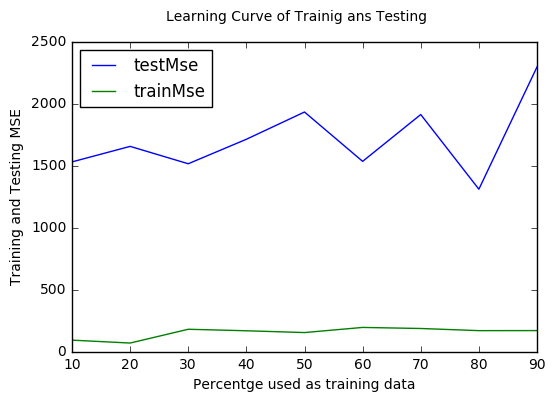

In [47]:
plt.plot([i * 10 for i in range(1,10)], testMse, label='testMse')
plt.plot([i * 10 for i in range(1,10)], trainMse, label='trainMse')
plt.legend(loc='best')
plt.suptitle('Learning Curve of Trainig ans Testing')
plt.xlabel('Percentge used as training data')
plt.ylabel('Training and Testing MSE')

In [59]:
mask1 = (df5['settledate'] < datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
training= df5.loc[mask1]
mask2 = (df5['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
test= df5.loc[mask2]

col_list = list(df5)
col_list[4:155]
x_list=[0]
x_list.extend(col_list[4:155])

X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]



regres = RandomForestRegressor(n_estimators=1000, max_features="sqrt", n_jobs=-1, oob_score = True)
regres.fit(X_train, y_train)
pred = regres.predict(X_test)
print("Mean squared error - Test Set: %.6f"
  % np.mean((pred - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_test, y_test))

pred_train = regres.predict(X_train)
print("Mean squared error - Training Set: %.6f"
  % np.mean((pred_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_train, y_train))




Mean squared error - Test Set: 1745.708064
Variance score: -0.02
Mean squared error - Training Set: 59.041008
Variance score: 0.91


### performance analysis

[[ 1.          0.18294445]
 [ 0.18294445  1.        ]]


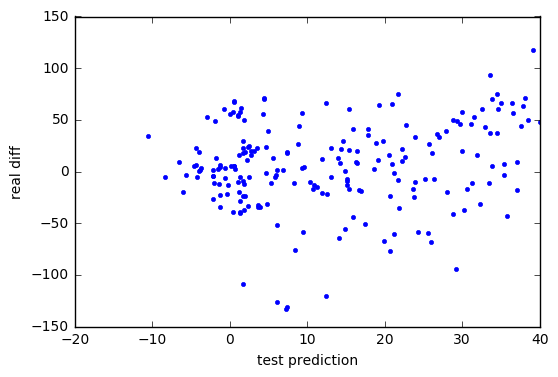

In [60]:
# scatter plot of real difference over prediction on test set
import numpy
plt.plot(pred, y_test, ".")
plt.ylabel('real diff')
plt.xlabel('test prediction')
print numpy.corrcoef(pred,y_test)

[[ 1.          0.98826581]
 [ 0.98826581  1.        ]]


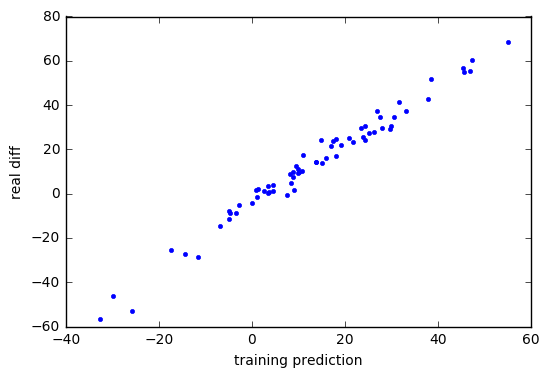

In [61]:
# scatter plot of real difference over prediction on training set 
plt.plot(pred_train, y_train, ".")
plt.ylabel('real diff')
plt.xlabel('training prediction')
print numpy.corrcoef(pred_train,y_train)

In [28]:
regres.oob_prediction_

array([  6.70505291,   4.36773224,  11.19826558,  10.00166205,
         8.05259669,   4.94099738,  14.5468    ,   6.72961644,
        10.54262338,   9.67234783,   0.08419558,   9.22598916,
        -1.41184987,   3.64866485,  -0.62002849,   5.29290761,
        19.38431937,  -2.16147453,   3.64704678,  17.24368116,
        25.96759104,  14.92337079,  14.39678063,  14.69408333,
        23.88053708,  17.9197043 ,   2.86929577,   5.13754522,
        22.35290055,  14.93677083,  28.27220159,   0.6490407 ,
         4.0197019 ,   9.0997654 ,   9.694573  ,  12.01495935,
        26.46204545,  28.33926431,  21.65297003,  26.40568783,
        28.58759259,  27.35710983,  28.43851429,  21.34656593,
        23.32790155,  11.44438642,  23.92865979,   6.52703412,
         7.08918848,  -3.68275281,  16.67371429,   0.56407713,
         7.26917143,   2.81506631,   3.64934659,   6.3271618 ,
         9.10191977,  14.51804233,  19.30757746,  29.7726361 ,
        24.29145889,  13.04921466,  10.05299728,  14.70

[[ 1.          0.69596005]
 [ 0.69596005  1.        ]]


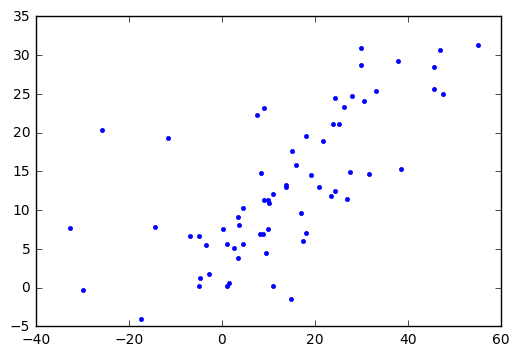

In [62]:
pred_train
plt.plot(pred_train, regres.oob_prediction_, ".")
print numpy.corrcoef(pred_train,regres.oob_prediction_)

# Strategies

### Add prediction to test set 

In [63]:
# get dictionary for ((today's date, settlement's date): prediction)
def createPredDict(row, pred_dict):
    if not pred_dict.has_key((row['todaydate'],row['settledate'])):
        pred_dict[(row['todaydate'],row['settledate'])] = row['pred']

def getPredict(df):
    """get predition for each today's date and settledate
    """
    prediction = {}
    df.apply(lambda row: createPredDict(row, prediction), axis=1)
    return prediction

predAll = numpy.append(pred_train,pred,axis=0)
df5['pred'] = predAll.tolist()
predDict = getPredict(df5)

# farward test
1.Date after 20170811 doesn't has settlement price
2.We want to get their settlement price prediction

In [40]:
df5

,todaydate,settledate,0,1,2,3,4,5,6,7,...,145,146,147,148,149,150,151,152,target,pred
0,2013-12-03,2013-12-06,3.0,1805.09,1795.15,1.0,1795.0,7.00,9884.0,1800.90,...,0.375,13515.0,1800.90,1802.75,1.050035,0.333333,1.050035,0.333333,9.94,8.67147
1,2013-12-04,2013-12-06,2.0,1805.09,1792.81,1.0,1795.0,6.55,10788.0,1795.15,...,1.900,7545.0,1795.15,1807.23,1.354092,0.791667,1.354092,0.791667,12.28,10.98839
2,2014-02-19,2014-02-28,9.0,1859.45,1828.75,0.0,1825.0,12.65,5500.0,1840.76,...,32.950,10166.0,1840.76,1819.26,1.895934,1.132302,0.996471,0.775294,30.70,25.53732
3,2014-02-26,2014-02-28,2.0,1859.45,1845.16,1.0,1845.0,6.15,7469.0,1843.09,...,0.400,24789.0,1843.09,1828.75,0.988161,0.695652,0.988161,0.695652,14.29,12.50253
4,2014-03-12,2014-03-14,2.0,1841.13,1868.20,1.0,1865.0,8.20,5263.0,1867.63,...,19.700,11149.0,1867.63,1873.81,1.092825,0.697345,0.957489,1.028721,-27.07,-14.55751
5,2014-04-09,2014-04-11,2.0,1815.69,1872.18,0.0,1870.0,6.20,5764.0,1851.96,...,22.500,8802.0,1851.96,1890.90,1.076697,2.153110,1.076697,2.153110,-56.49,-35.22301
6,2014-05-15,2014-05-23,8.0,1900.53,1870.85,1.0,1875.0,9.95,6739.0,1888.53,...,32.650,11294.0,1888.53,1875.63,1.000000,1.000000,1.000000,1.000000,29.68,23.04891
7,2014-06-02,2014-06-06,4.0,1949.44,1924.97,1.0,1925.0,6.80,10210.0,1923.57,...,29.350,7545.0,1923.57,1900.53,1.001327,1.037102,1.001327,1.037102,24.47,19.24068
8,2014-06-03,2014-06-06,3.0,1949.44,1924.24,1.0,1925.0,7.15,11204.0,1924.97,...,0.600,19208.0,1924.97,1911.91,1.325787,1.142857,1.325787,1.142857,25.20,20.46690
9,2014-06-04,2014-06-06,2.0,1949.44,1927.88,1.0,1930.0,6.35,12761.0,1924.24,...,28.450,11779.0,1924.24,1909.78,1.123522,1.635057,0.992501,1.131213,21.56,17.37571


In [64]:
## get dataframe for testing
mask3 = (cleandata['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
testdf= cleandata.loc[mask3]


In [65]:
## add sp500 difference prediction to each option

def getPred(row,pred_dict):
    if pred_dict.has_key((row['todaydate'],row['settledate'])):
        return pred_dict[(row['todaydate'],row['settledate'])]
    else:
        return 0

def changePred(df, pred_dict):
    pred0 = df.apply(lambda row: getPred(row, pred_dict), axis=1)
    df['pred'] = pred0
        
changePred(testdf, predDict)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
testdf

,todaydate,settledate,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred
55446,2015-11-11,2015-11-20,9,2075.00,2089.17,1,2075,15.850,32085,2081.72,2102.31,1.070785,0.419312,1.020288,0.754762,1,0.00,22.56814
54696,2015-11-11,2015-11-13,2,2075.00,2023.04,1,2075,7.800,12639,2081.72,2102.31,1.067483,0.230088,1.048619,0.537931,1,0.00,6.03886
54697,2015-11-11,2015-11-13,2,2075.00,2023.04,0,2075,9.400,10293,2081.72,2102.31,1.750808,0.954315,1.047207,1.372263,0,0.00,6.03886
55445,2015-11-11,2015-11-20,9,2075.00,2089.17,0,2075,18.650,25858,2081.72,2102.31,1.195690,1.226974,0.989515,1.247492,0,0.00,22.56814
55447,2015-11-11,2015-11-20,9,2075.00,2089.17,0,2075,18.300,25858,2081.72,2102.31,1.195690,1.203947,0.989515,1.224080,0,0.00,22.56814
55444,2015-11-11,2015-11-20,9,2075.00,2089.17,1,2075,15.550,32085,2081.72,2102.31,1.070785,0.411376,1.020288,0.740476,1,0.00,22.56814
64248,2016-03-04,2016-03-18,14,1999.99,2049.58,1,2000,21.150,126696,1993.40,1948.05,0.999590,1.076336,0.999590,1.076336,1,0.01,38.46498
64249,2016-03-04,2016-03-18,14,1999.99,2049.58,0,2000,26.250,101355,1993.40,1948.05,1.013023,0.913043,1.013023,0.913043,0,0.01,38.46498
64247,2016-03-04,2016-03-18,14,1999.99,2049.58,0,2000,26.250,101355,1993.40,1948.05,1.013023,0.913043,1.013023,0.913043,0,0.01,38.46498
64246,2016-03-04,2016-03-18,14,1999.99,2049.58,1,2000,21.150,126696,1993.40,1948.05,0.999590,1.076336,0.999590,1.076336,1,0.01,38.46498


## First Strategy

In [67]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price and row.optiontype == 0: #put
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price and row.optiontype == 1: #call
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [182]:
## result of first strategy
positivedf = testdf 
neagtivedf = testdf 
positivedf = testdf[testdf.pl > 0]
negativedf = testdf[testdf.pl < 0]

### plot histogram for total profit and loss based on each other numbers day out 


In [219]:
### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos = genPositiveDataframe(positivedf)
neg = genNegativeDataframe(negativedf)
plotdf = pos.join(neg.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf['loss'].fillna(0, inplace=True)
plotdf['lossCount'].fillna(1, inplace=True)
plotdf['lossAvg'].fillna(0, inplace=True)
plotdf.numofdays = plotdf.numofdays.astype(int)
plotdf.set_index('numofdays', inplace=True)


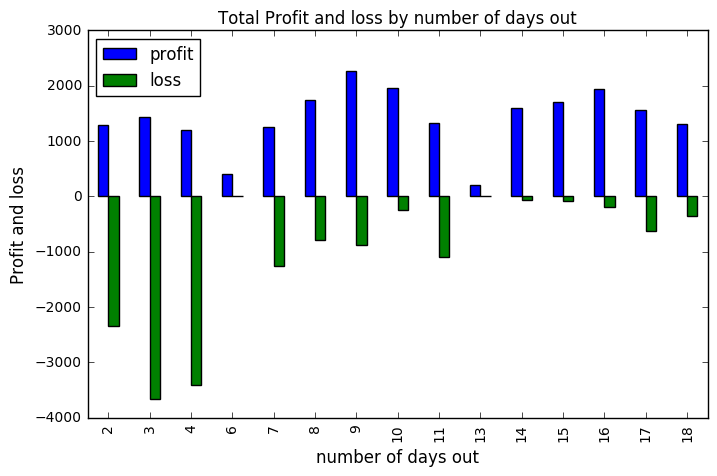

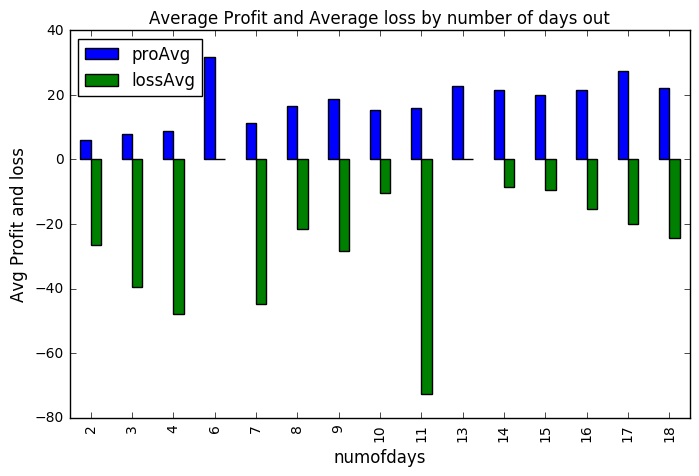

In [221]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(8, 5), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(8, 5), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

In [152]:
print negativedf.describe()
print positivedf.describe()
print "profit is "+ str(positivedf['pl'].sum())
print "loss is " + str(negativedf['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    231.000000      231.000000       231.000000  231.000000   
mean       6.805195     2101.227359      2057.626840    0.160173   
std        4.859877       86.650679       117.825848    0.367563   
min        2.000000     1923.670000      1880.020000    0.000000   
25%        3.000000     2077.070000      1970.890000    0.000000   
50%        4.000000     2088.870000      2023.040000    0.000000   
75%        9.000000     2173.535000      2147.260000    0.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    231.000000          231.000000     231.000000   231.000000   
mean    2091.709957            9.502706   19882.939394  2099.403377   
std       94.378967            5.378696   19599.948773    87.928567   
min     1895.000000            0.225000    5002.000000  1893.360000   
25%     2055.000000            5

testdf is all the options that we are going to trade.

putdf are put options and calldf are call options

generate scatter points for put and call option where x axis is prediction and y is profit

In [39]:
interestedDf = testdf
interestedDf = testdf[testdf.pl!=0]
putDf = interestedDf[interestedDf.optiontype == 0]
callDf = interestedDf[interestedDf.optiontype == 1]

In [40]:
print putDf.describe()
print callDf.describe()

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    941.000000      941.000000       941.000000       941.0   
mean       8.153029     2060.514198      2068.075590         0.0   
std        5.093171       84.206958        92.192552         0.0   
min        2.000000     1851.860000      1880.020000         0.0   
25%        3.000000     1995.310000      2023.040000         0.0   
50%        8.000000     2075.000000      2075.150000         0.0   
75%       11.000000     2099.600000      2091.690000         0.0   
max       18.000000     2293.080000      2347.220000         0.0   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    941.000000          941.000000     941.000000   941.000000   
mean    2044.723698           12.636637   20886.708820  2058.755175   
std       84.681997            7.993001   21773.077388    86.440320   
min     1825.000000            0.425000    5002.000000  1852.210000   
25%     1980.000000            6

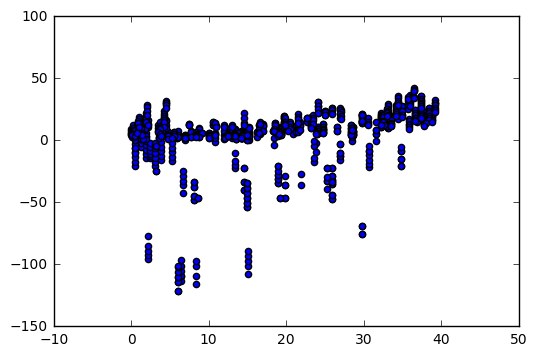

In [41]:
plt.scatter(putDf['pred'], putDf['pl'])

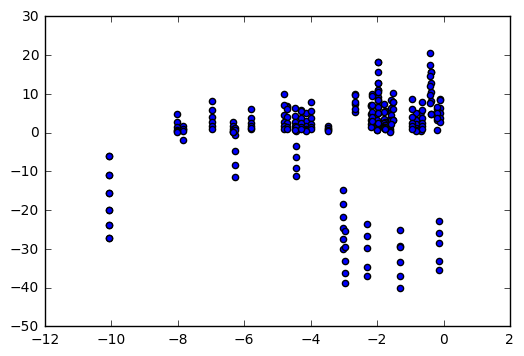

In [42]:
plt.scatter(callDf['pred'], callDf['pl'])

## Second Strategy

In [155]:
testdf2 = testdf
testdf2['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price - row.pred and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price  - row.pred and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf2, predDict)
testdf2['pl'].fillna(0, inplace=True)
    

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### result of second strategy

In [156]:
positivedf2 = testdf2 
neagtivedf2 = testdf2 
positivedf2 = testdf2[testdf2.pl > 0]
negativedf2 = testdf2[testdf2.pl < 0]
print negativedf2.describe()
print positivedf2.describe()
print "profit is "+ str(positivedf2['pl'].sum())
print "loss is " + str(negativedf2['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    128.000000      128.000000       128.000000  128.000000   
mean       7.164062     2136.395781      2096.858438    0.226562   
std        4.856650       74.025176       118.178802    0.420252   
min        2.000000     1938.680000      1880.020000    0.000000   
25%        3.000000     2081.720000      2012.370000    0.000000   
50%        7.000000     2112.130000      2077.990000    0.000000   
75%        9.000000     2186.240000      2147.260000    0.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    128.000000          128.000000     128.000000   128.000000   
mean    2125.859375            6.989258   22503.554688  2134.805000   
std       86.872858            4.272309   20017.569382    72.455648   
min     1910.000000            0.225000    5055.000000  1923.670000   
25%     2065.000000            4

### plot histogram for total profit and loss based on each other numbers day out 

In [222]:
### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos2 = genPositiveDataframe(positivedf2)
neg2 = genNegativeDataframe(negativedf2)
plotdf2 = pos2.join(neg2.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf2['loss'].fillna(0, inplace=True)
plotdf2['lossCount'].fillna(1, inplace=True)
plotdf2['lossAvg'].fillna(0, inplace=True)
plotdf2.numofdays = plotdf2.numofdays.astype(int)
plotdf2.set_index('numofdays', inplace=True)

In [223]:
plotdf2

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2,324.605,114.0,2.847412,-679.540,21.0,-32.359048
3,296.625,73.0,4.063356,-921.475,21.0,-43.879762
4,310.595,60.0,5.176583,-1076.280,17.0,-63.310588
6,44.500,2.0,22.250000,0.000,1.0,0.000000
7,203.500,39.0,5.217949,-413.100,10.0,-41.310000
8,103.640,23.0,4.506087,-293.200,15.0,-19.546667
9,270.640,31.0,8.730323,-189.330,13.0,-14.563846
10,438.320,48.0,9.131667,-111.050,10.0,-11.105000
11,175.655,20.0,8.782750,-307.880,3.0,-102.626667


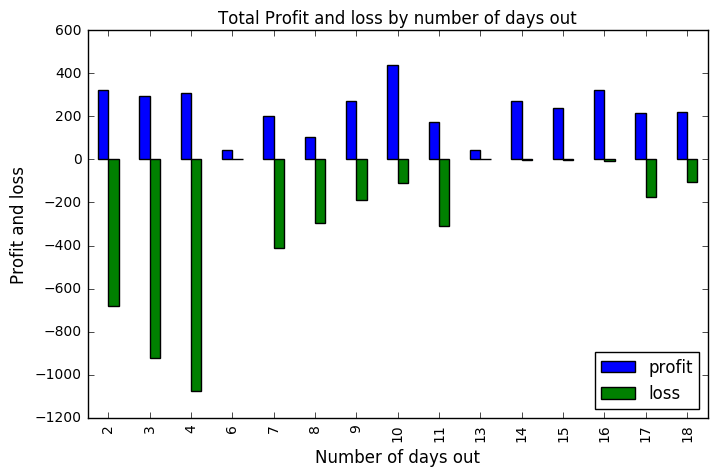

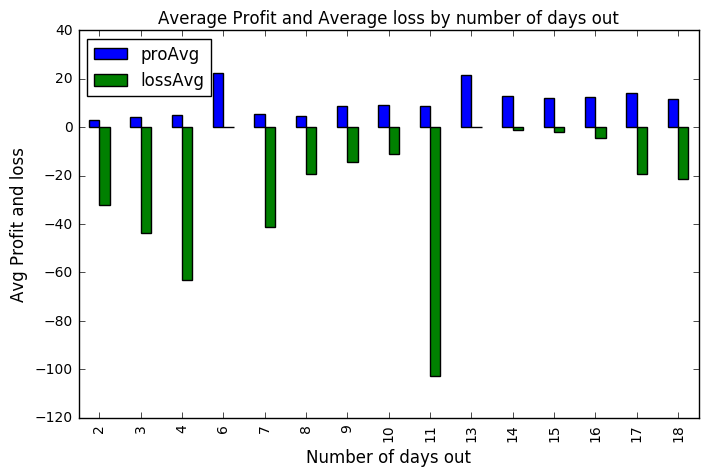

In [224]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf2[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(8, 5), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf2[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(8, 5), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

### seperate analysis of call and put option 

In [46]:
interestedDf2 = testdf2
interestedDf2 = testdf2[testdf2.pl!=0]
putDf2 = interestedDf2[interestedDf2.optiontype == 0]
callDf2 = interestedDf2[interestedDf2.optiontype == 1]

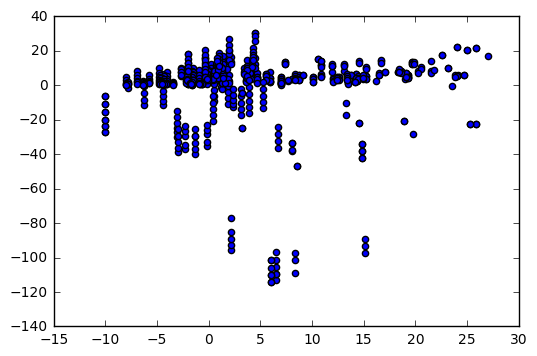

In [47]:
## scatter plot of put options' prediction over its P&l
plt.scatter(putDf2['pred'], putDf2['pl'])


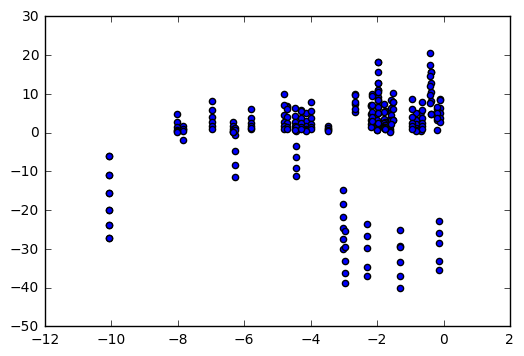

In [48]:
## scatter plot of call options' prediction over its P&l
plt.scatter(callDf['pred'], callDf['pl'])

### analysis based on the days to settle date

In [50]:
X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]
pred = regres.predict(X_test)
pred_train = regres.predict(X_train)



In [51]:
# convert X_test, y_test, pred to df
df6 = pd.DataFrame(X_test.tolist())
df6['real'] = y_test.tolist()
df6['pred'] = pred.tolist()

In [52]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row[0] not in dayList:
        dayList.append(row[0])

def getDayDiff(df):
    """get vol and sp500 today price for each day
    """
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(df6)

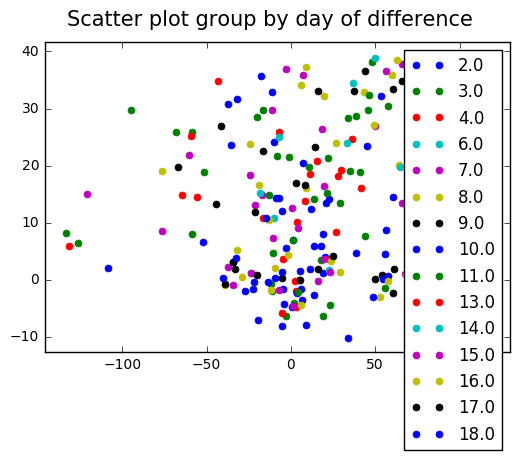

In [53]:
groups = df6.groupby(0)
fig, ax = plt.subplots()
fig.suptitle('Scatter plot group by day of difference', fontsize=15)
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
ax.legend()

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


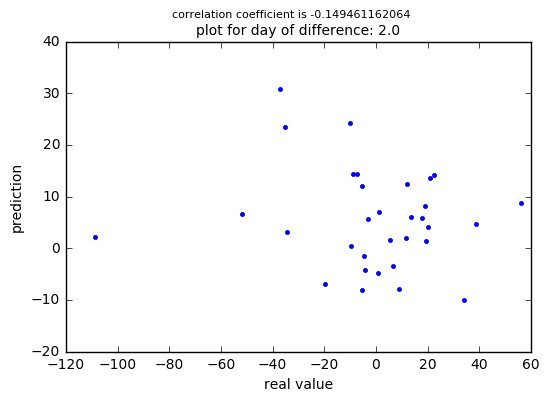

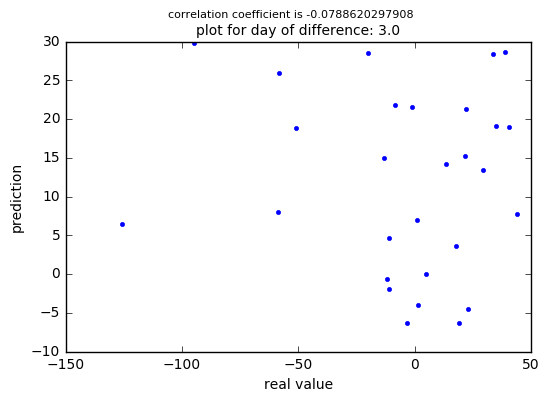

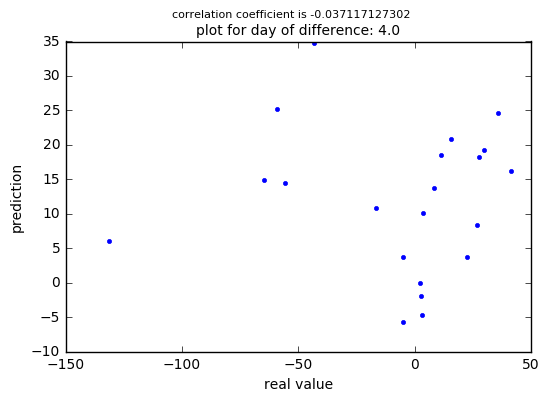

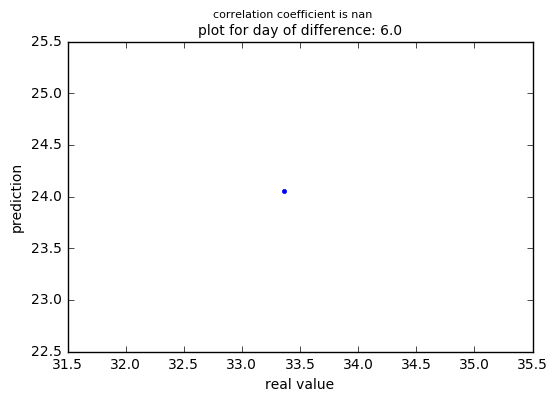

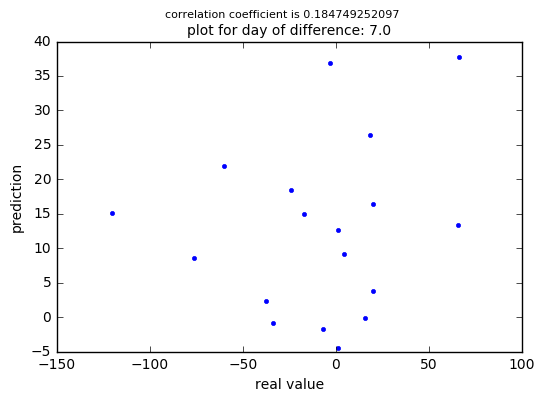

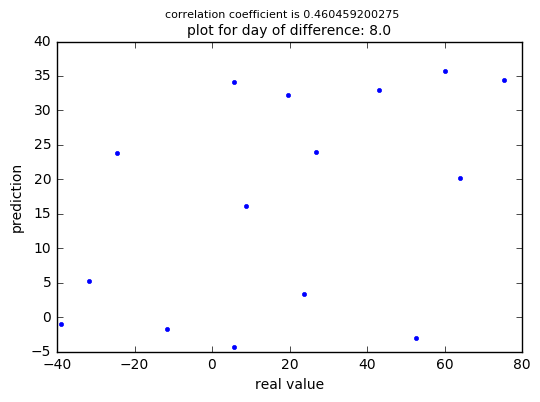

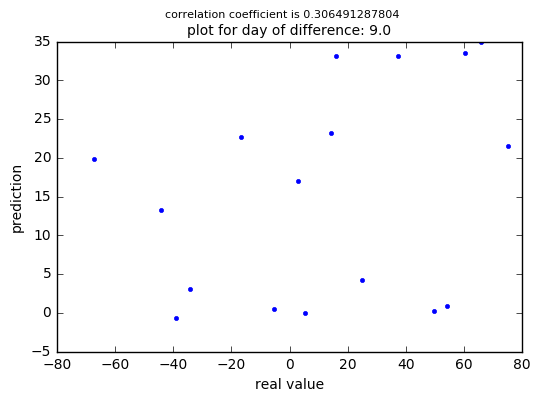

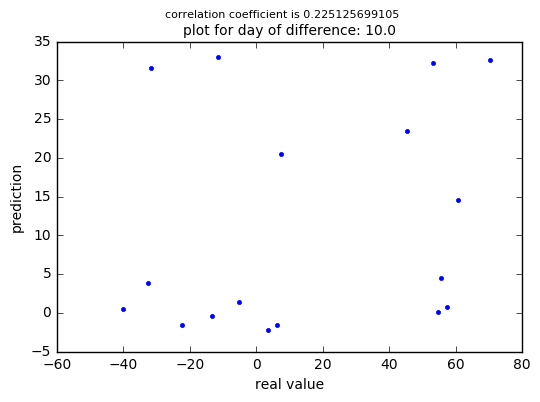

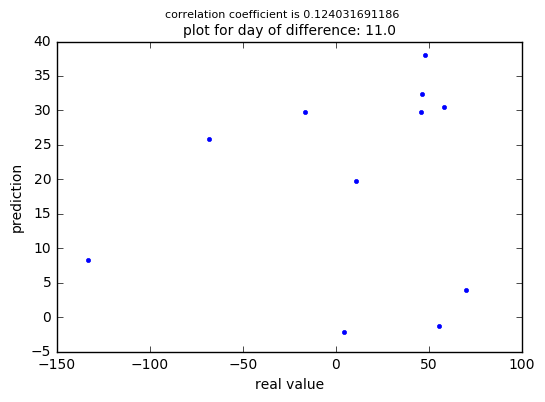

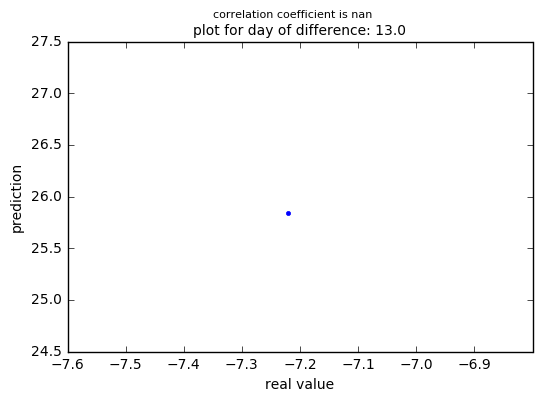

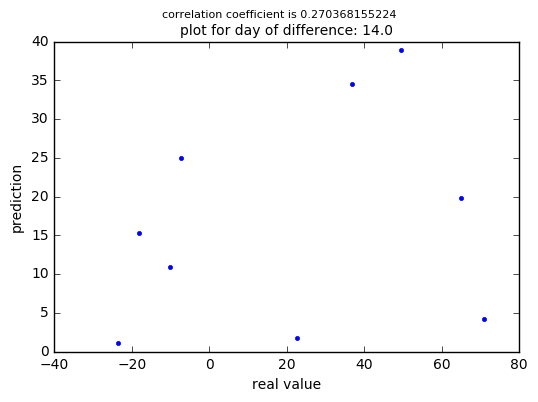

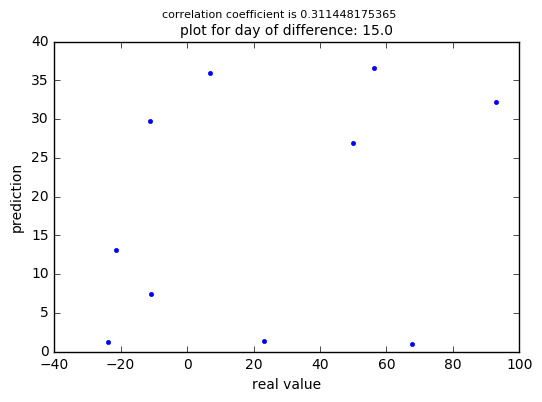

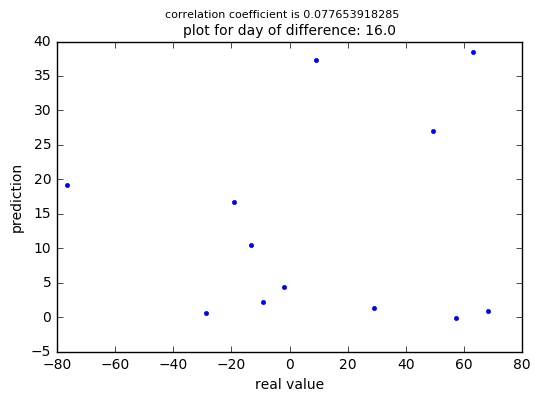

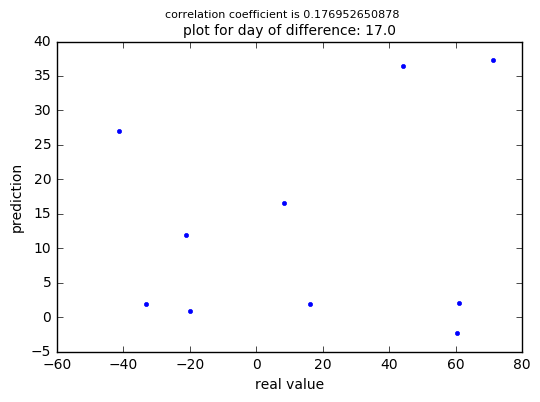

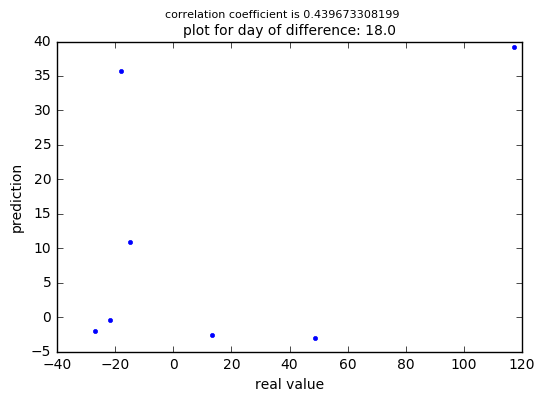

In [54]:
## generate correlation group by day of difference one by one, calculate correlation coefficient 
corrList = []
def oneDayDiff(key, df):
    df0 = df
    df0 = df[df[0]==key]
    fig = plt.figure()
    plt.xlabel('real value')
    plt.ylabel('prediction')
    plt.title('plot for day of difference: ' + str(key),  fontsize=10)
    plt.suptitle('correlation coefficient is '+ str(numpy.corrcoef(df0['real'],df0['pred'])[0][1]), fontsize=8)
    plt.plot(df0['real'], df0['pred'], ".")
    return numpy.corrcoef(df0['real'],df0['pred'])[0][1]
    
    
def allDayDiff(df, dayList, corr):
    for d in dayList:
        res = oneDayDiff(d, df)
        corr.append(res)
    return corr

corrList = allDayDiff(df6, dayDiffList, corrList)

## Third Startegy

In [166]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike < row.today_sp_price + row.optionclosingprice and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price - row.optionclosingprice  and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
### result of third strategy

In [167]:
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)
interestedDf3 = testdf
interestedDf3 = testdf[testdf.pl!=0]

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [168]:
positivedf = interestedDf3
positivedf = interestedDf3[interestedDf3.pl > 0]
negadf = interestedDf3
negadf = interestedDf3[interestedDf3.pl < 0]

In [61]:
negadf.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,7.067511,2106.656519,2076.518270,0.259494,2105.031646,16.557584,19301.643460,2105.696730,2109.652743,1.088077,1.166687,1.032069,1.081594,0.259494,14.063059,9.982798,-3.282474e+01
std,5.197137,98.379336,133.021079,0.438820,98.360498,9.444526,19927.860506,99.239716,89.126385,0.221838,1.048945,0.131986,0.540661,0.438820,8.651446,12.441685,3.038448e+01
min,2.000000,1890.280000,1880.020000,0.000000,1895.000000,0.225000,5002.000000,1893.360000,1851.860000,0.581292,0.071429,0.708325,0.173529,0.000000,0.000000,-10.073210,-1.311600e+02
25%,3.000000,2064.110000,1970.890000,0.000000,2060.000000,8.550000,7200.000000,2065.300000,2079.397500,0.994793,0.590716,0.990398,0.721191,0.000000,6.330000,-0.139310,-4.477000e+01
50%,4.000000,2094.650000,2040.040000,0.000000,2090.000000,15.825000,11321.000000,2099.130000,2099.330000,1.006182,0.981707,1.000000,1.000000,0.000000,13.680000,6.661970,-2.524500e+01
75%,10.000000,2179.980000,2187.020000,1.000000,2175.000000,23.287500,21959.750000,2176.120000,2180.380000,1.123259,1.115528,1.038984,1.215744,1.000000,21.397500,19.776800,-9.817500e+00
max,18.000000,2328.250000,2347.220000,1.000000,2345.000000,43.500000,132806.000000,2316.100000,2294.690000,2.291132,7.949367,2.107455,3.573333,1.000000,29.760000,34.752990,-4.263256e-14


In [62]:
positivedf.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000
mean,8.387357,2082.975999,2102.314378,0.218561,2078.954270,16.734294,21326.975790,2080.965138,2074.354593,1.097123,1.053904,1.034207,1.015994,0.218561,14.908911,15.619906,14.320387
std,5.094721,101.190654,95.233499,0.413409,103.335193,11.624840,22048.417459,102.069901,107.207291,0.236081,1.374418,0.110120,0.602348,0.413409,8.841815,14.975862,10.931913
min,2.000000,1851.860000,1880.330000,0.000000,1825.000000,0.225000,5005.000000,1852.210000,1851.860000,0.499007,0.021718,0.499007,0.087121,0.000000,0.000000,-8.036940,0.090000
25%,3.000000,1999.990000,2049.580000,0.000000,2000.000000,6.975000,7759.000000,1993.400000,1987.660000,0.999826,0.439463,0.996879,0.697043,0.000000,7.165000,0.899660,5.375000
50%,8.000000,2079.060000,2089.170000,0.000000,2070.000000,14.800000,13175.000000,2080.410000,2083.580000,1.021587,0.836570,1.003088,0.937500,0.000000,14.560000,14.393190,11.650000
75%,11.000000,2168.480000,2170.060000,0.000000,2165.000000,24.225000,24099.000000,2165.170000,2163.790000,1.132762,1.049433,1.042602,1.111111,0.000000,22.510000,30.487710,21.300000
max,18.000000,2328.250000,2347.220000,1.000000,2355.000000,56.200000,149669.000000,2316.100000,2298.370000,4.116423,14.444444,2.193734,4.575758,1.000000,29.990000,39.235960,55.850000


### plot histogram for total profit and loss based on each other numbers day out 


In [226]:
### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos3 = genPositiveDataframe(positivedf)
neg3 = genNegativeDataframe(negativedf)
plotdf3 = pos3.join(neg3.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf3['loss'].fillna(0, inplace=True)
plotdf3['lossCount'].fillna(1, inplace=True)
plotdf3['lossAvg'].fillna(0, inplace=True)
plotdf3.numofdays = plotdf3.numofdays.astype(int)
plotdf3.set_index('numofdays', inplace=True)


In [171]:
plotdf3

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2.0,1291.235,212.0,6.090731,-996.100,38.0,-26.213158
3.0,1434.860,184.0,7.798152,-1798.955,44.0,-40.885341
4.0,1190.565,137.0,8.690255,-1997.640,41.0,-48.722927
6.0,410.550,13.0,31.580769,0.000,1.0,0.000000
7.0,1249.860,112.0,11.159464,-702.550,16.0,-43.909375
8.0,1731.290,104.0,16.647019,-332.560,18.0,-18.475556
9.0,2257.090,121.0,18.653636,-434.440,21.0,-20.687619
10.0,1955.660,128.0,15.278594,-111.250,11.0,-10.113636
11.0,1329.475,84.0,15.827083,-672.070,10.0,-67.207000


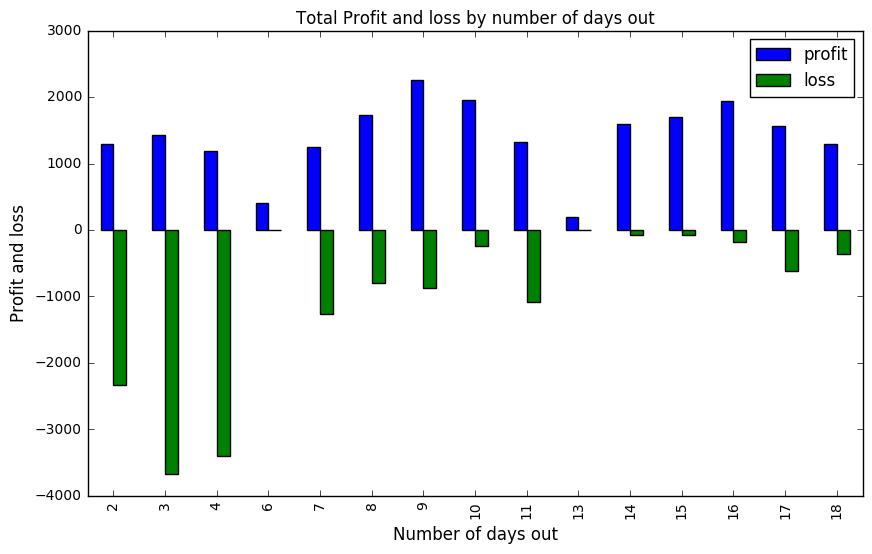

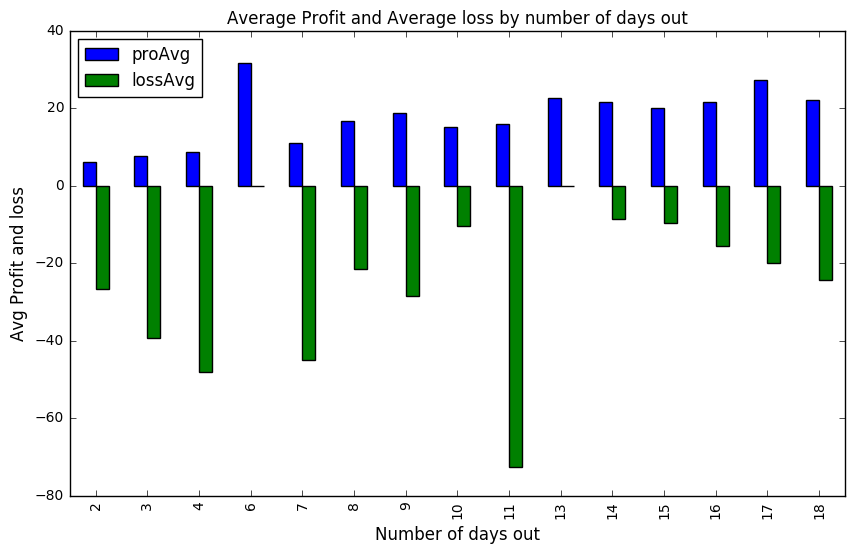

In [227]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf3[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf3[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

In [173]:
def plSummary(df):
    positivedf = df
    neagtivedf = df
    positivedf = df[df.pl > 0]
    negativedf = df[df.pl < 0]
    print "profit is "+ str(positivedf['pl'].sum())
    print "loss is " + str(negativedf['pl'].sum())

    
interestedDf3.describe()
plSummary(interestedDf3)

profit is 21167.895
loss is -14986.265


### calculate sharpe ratio based on days to settle date and plot P&l distribution based on days to settle date

In [64]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row.daystosettle not in dayList:
        dayList.append(row.daystosettle)

def getDayDiff(df):
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(interestedDf3)

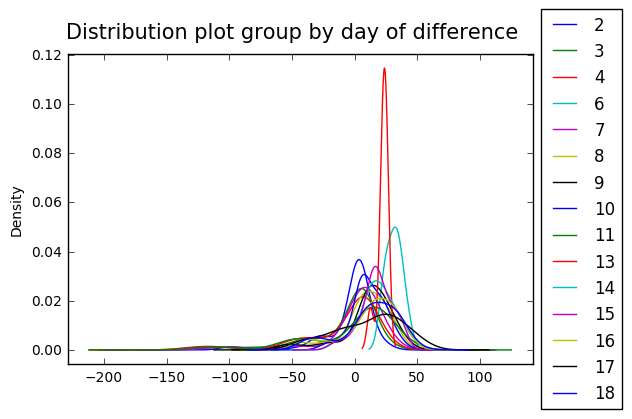

In [65]:
## draw pl distribution for each number of days 
def plotDistribution(df):
    groups = df.groupby('daystosettle')
    fig, ax = plt.subplots()
    fig.suptitle('Distribution plot group by day of difference', fontsize=15)
    ax.margins(0.05) 
    
    for name, group in groups:
        group.pl.plot(kind='kde', label=name)
        ##ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
   
plotDistribution(interestedDf3)

In [66]:
def computeSharpeRatio(df):
    return df['pl'].mean() / df['pl'].std()

def getSharpeRatio(df):
    groups = df.groupby('daystosettle')
    res = []
    for name, group in groups:
        tmp = computeSharpeRatio(group)
        res.append((name, tmp))
    return res

SharpeList = getSharpeRatio(interestedDf3)
print SharpeList

[(2, -0.16071719196382112), (3, -0.27994212792715356), (4, -0.29643507984297596), (6, 4.8741661189301286), (7, -0.007739878978270282), (8, 0.45419014649332945), (9, 0.51249903926223273), (10, 0.82941549162392758), (11, -0.073704600255705202), (13, 5.611222538009363), (14, 1.3293559450765033), (15, 1.3659055129805246), (16, 0.51940776431427904), (17, 0.40015333581427176), (18, 0.56776639304163645)]


# Comparison with Random Startegies 

In [68]:
## get a sample of random profit 

import random 
def getSamples(num, testdf):
    res = []
    i = 1
    while i <= num:
        i += 1
        experimentalDf = testdf
        experimentalDf['pl'] = 0
        experimentalDf['buyorsell'] = 0
        getBuyOrSell(experimentalDf, options)
        getPl(experimentalDf)
        experimentalDf['pl'].fillna(0, inplace=True)
        res.append(experimentalDf['pl'].sum())
        print "profit is " + str(experimentalDf['pl'].sum())
    return res

# random choice either buy or sell or do nothing 
options = [-1,1, 0]

def getBuyOrSell(df, options):
    option = df.apply(lambda row: buyOrSell(row, options), axis=1)
    df['buyorsell'] = option

def buyOrSell(row, options):
    return random.choice(options)


# computer p&l based on the random choice
def compPL(row):
    if row.buyorsell == 0:
        return 0
    elif row.buyorsell == 1:
        pl = -row.optionclosingprice
        if row.optiontype == 1:
            if row.optionstrike < row.settle_sp_price:
                pl = pl + row.settle_sp_price - row.optionstrike
        else:
            if row.optionstrike > row.settle_sp_price:
                pl = pl + row.optionstrike - row.settle_sp_price
        return pl
    else:
        pl = row.optionclosingprice
        if row.optiontype == 1:
            if row.optionstrike < row.settle_sp_price:
                pl = pl -(row.settle_sp_price - row.optionstrike)
        else:
            if row.optionstrike > row.settle_sp_price:
                pl = pl -(row.optionstrike - row.settle_sp_price)
        return pl
        
def getPl(df):
    pl0 = df.apply(lambda row: compPL(row), axis=1)
    df['pl'] = pl0
            
sample = getSamples(10, testdf)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

profit is -272.19
profit is -382.895
profit is -2595.95
profit is -1104.705
profit is 3058.255
profit is 1814.425
profit is -1516.715
profit is -1532.285
profit is 2063.4
profit is -2012.26


In [69]:
## test weather third strategy and random starategy are from the same distribution
from scipy.stats import ttest_ind

## gen a list of PL from third strategy
def genStrategyList(res, num):
    i  = 1
    reslist = []
    while i <= num:
        i = i+1
        reslist.append(res)
    return reslist
stra3 = genStrategyList(6529,10)

## null hypothesis: third strategy and random starategy are from the same distribution; get p value
ttest_ind(sample,stra3)



Ttest_indResult(statistic=-11.164170300057313, pvalue=1.5988088428050065e-09)

# Train binary classifier

In [ ]:
### get get correct result, you need to get df5 before the last training part. Becasue in the last training part, 
### we added settle price - today price as target

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [17]:
def target(row):
    if row[1] >= row[2]:
        return 1
    else:
        return 0

def addTarget(df):
    """ target = settle price - today's price
    """
    t = df.apply(lambda row: target(row), axis=1)
    df['target'] = t

addTarget(df5)

In [20]:
### There are 276 rows in df5.
### plot learning curve


def crossTrain(df):
    trainScore = []
    testScore = []
    for i in range (1,10):
        print "Training percentage: " + str(i * 10)
        trainNum = 276 * i /10
        testNum = 276 - trainNum 
        training = df.head(trainNum)
        test = df.tail(testNum)
        col_list = list(df)
        col_list[4:155]
        x_list=[0]
        x_list.extend(col_list[4:155])

        X_test = test.as_matrix(x_list)
        y_test = test.as_matrix(['target'])[:,0]

        X_train = training.as_matrix(x_list)
        y_train = training.as_matrix(['target'])[:,0]
        
        regres = RandomForestClassifier(n_estimators=50, max_features="sqrt", n_jobs=-1, oob_score = True)
        regres.fit(X_train, y_train)
        pred = regres.predict(X_test)
        pred_train = regres.predict(X_train)
        ##print "oobscore", regres.oob_score_
        pscore = metrics.accuracy_score(y_test, pred)
        pscore_train = metrics.accuracy_score(y_train, pred_train)
        trainScore.append(pscore_train)
        testScore.append(pscore)
        print "Test accuracy: ", pscore
        print "Training accuracy: ", pscore_train
                                        
    return (trainScore, testScore)

(trainScore, testScore) = crossTrain(df5)
    

Training percentage: 10
Test accuracy:  0.602409638554
Training accuracy:  1.0
Training percentage: 20
Test accuracy:  0.533936651584
Training accuracy:  1.0
Training percentage: 30
Test accuracy:  0.494845360825
Training accuracy:  1.0
Training percentage: 40
Test accuracy:  0.469879518072
Training accuracy:  0.990909090909
Training percentage: 50
Test accuracy:  0.420289855072
Training accuracy:  1.0
Training percentage: 60
Test accuracy:  0.396396396396
Training accuracy:  1.0
Training percentage: 70
Test accuracy:  0.385542168675
Training accuracy:  1.0
Training percentage: 80
Test accuracy:  0.535714285714
Training accuracy:  1.0
Training percentage: 90
Test accuracy:  0.464285714286
Training accuracy:  1.0


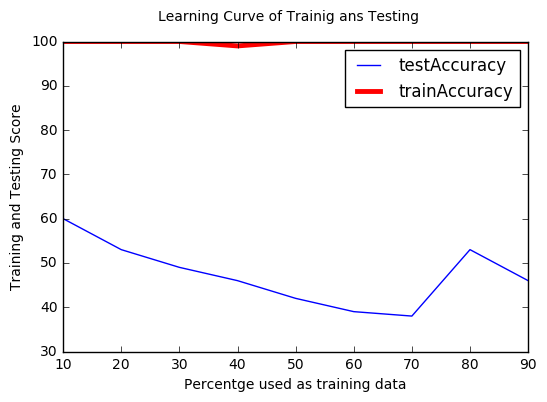

In [21]:
plt.plot([i * 10 for i in range(1,10)], [int(i * 100) for i in testScore], label='testAccuracy')
plt.plot([i * 10 for i in range(1,10)],[int(i * 100) for i in trainScore], label='trainAccuracy',color = 'red',linewidth=3.5)
plt.legend(loc='best')
plt.suptitle('Learning Curve of Trainig ans Testing')
plt.xlabel('Percentge used as training data')
plt.ylabel('Training and Testing Score')

In [ ]:
### according to the learning graph, we choose 10% as trainig data, becasue it has the highest test accuracy 

In [22]:
trainNum = 276 * 1 /10
testNum = 276 - trainNum
training = df5.head(trainNum)
test = df5.tail(testNum)
col_list = list(df5)
col_list[4:155]
x_list=[0]
x_list.extend(col_list[4:155])

X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]

regres = RandomForestClassifier(n_estimators=50, max_features="sqrt", n_jobs=-1, oob_score = True)
regres.fit(X_train, y_train)
pred = regres.predict(X_test)
pred_train = regres.predict(X_train)
print "oobscore", regres.oob_score_
pscore = metrics.accuracy_score(y_test, pred)
pscore_train = metrics.accuracy_score(y_train, pred_train)
trainScore.append(pscore_train)
testScore.append(pscore)
print "Test accuracy: ", pscore
print "Training accuracy: ", pscore_train

oobscore 0.62962962963
Test accuracy:  0.598393574297
Training accuracy:  1.0


In [71]:
training

,todaydate,settledate,0,1,2,3,4,5,6,7,...,144,145,146,147,148,149,150,151,152,target
0,2013-12-03,2013-12-06,3.0,1805.09,1795.15,1.0,1795.0,7.00,9884.0,1800.90,...,1825.0,0.375,13515.0,1800.90,1802.75,1.050035,0.333333,1.050035,0.333333,1
1,2013-12-04,2013-12-06,2.0,1805.09,1792.81,1.0,1795.0,6.55,10788.0,1795.15,...,1765.0,1.900,7545.0,1795.15,1807.23,1.354092,0.791667,1.354092,0.791667,1
2,2014-02-19,2014-02-28,9.0,1859.45,1828.75,1.0,1825.0,14.85,10363.0,1840.76,...,1800.0,5.600,10286.0,1840.76,1819.26,1.043840,1.750000,1.043840,1.750000,1
3,2014-02-26,2014-02-28,2.0,1859.45,1845.16,1.0,1845.0,6.15,7469.0,1843.09,...,1870.0,0.400,24789.0,1843.09,1828.75,0.988161,0.695652,0.988161,0.695652,1
4,2014-03-12,2014-03-14,2.0,1841.13,1868.20,1.0,1865.0,8.05,5263.0,1867.63,...,1850.0,1.925,8157.0,1867.63,1873.81,1.332843,0.326271,0.999020,0.487342,0
5,2014-04-09,2014-04-11,2.0,1815.69,1872.18,0.0,1870.0,6.20,5764.0,1851.96,...,1850.0,22.250,8802.0,1851.96,1890.90,1.076697,2.129187,1.076697,2.129187,0
6,2014-05-15,2014-05-23,8.0,1900.53,1870.85,1.0,1875.0,9.95,6739.0,1888.53,...,1900.0,32.000,11294.0,1888.53,1875.63,1.000000,1.000000,1.000000,1.000000,1
7,2014-06-02,2014-06-06,4.0,1949.44,1924.97,1.0,1925.0,6.80,10210.0,1923.57,...,1895.0,29.350,7545.0,1923.57,1900.53,1.001327,1.037102,1.001327,1.037102,1
8,2014-06-03,2014-06-06,3.0,1949.44,1924.24,1.0,1925.0,7.15,11204.0,1924.97,...,1950.0,0.600,19208.0,1924.97,1911.91,1.325787,1.142857,1.325787,1.142857,1
9,2014-06-04,2014-06-06,2.0,1949.44,1927.88,1.0,1930.0,6.35,12761.0,1924.24,...,1900.0,28.450,11779.0,1924.24,1909.78,1.123522,1.635057,0.992501,1.131213,1


In [88]:
test

,todaydate,settledate,0,1,2,3,4,5,6,7,...,144,145,146,147,148,149,150,151,152,target
27,2014-12-03,2014-12-05,2.0,2075.37,2074.33,1.0,2075.0,6.75,11502.0,2066.55,...,2050.0,25.050,17646.0,2066.55,2072.83,1.158939,0.902703,0.984820,1.240099,1
28,2015-01-05,2015-01-09,4.0,2044.81,2020.58,0.0,2020.0,15.30,5891.0,2058.20,...,2050.0,4.150,7083.0,2058.20,2090.57,1.000000,1.000000,1.000000,1.000000,1
29,2015-02-06,2015-02-13,7.0,2096.99,2055.47,0.0,2055.0,14.95,5150.0,2062.52,...,2085.0,3.400,5247.0,2062.52,1994.99,1.005365,0.673267,1.005365,0.673267,1
30,2015-02-06,2015-02-20,14.0,2110.30,2055.47,1.0,2060.0,19.35,7962.0,2062.52,...,2075.0,31.300,12321.0,2062.52,1994.99,1.000568,1.012945,1.000568,1.012945,1
31,2015-03-02,2015-03-06,4.0,2071.26,2117.39,1.0,2115.0,8.35,9963.0,2104.50,...,2090.0,27.300,12289.0,2104.50,2109.66,1.017638,1.026316,1.000000,1.392857,0
32,2015-03-02,2015-03-20,18.0,2108.67,2117.39,0.0,2115.0,19.50,7153.0,2104.50,...,2090.0,11.650,26077.0,2104.50,2109.66,1.000000,1.000000,1.000000,1.000000,0
33,2015-03-03,2015-03-20,17.0,2108.67,2107.78,0.0,2110.0,22.55,22932.0,2117.39,...,2090.0,15.000,26161.0,2117.39,2115.48,1.003221,1.287554,1.003221,1.287554,1
34,2015-03-04,2015-03-20,16.0,2108.67,2098.53,1.0,2100.0,18.05,77953.0,2107.78,...,2080.0,31.100,17128.0,2107.78,2113.81,1.000467,0.834899,1.000467,0.834899,1
35,2015-03-05,2015-03-20,15.0,2108.67,2101.04,0.0,2100.0,19.25,44167.0,2098.53,...,2120.0,8.600,12380.0,2098.53,2110.74,1.004218,1.042424,1.004218,1.042424,1
36,2015-03-06,2015-03-20,14.0,2108.67,2071.26,0.0,2070.0,21.25,15455.0,2101.04,...,2090.0,9.650,25318.0,2101.04,2104.50,0.976360,0.376953,0.976360,0.376953,1


## testing on first and second strategies

In [73]:
### Add prediction to test set

In [23]:
# get dictionary for ((today's date, settlement's date): prediction)
def createPredDict(row, pred_dict):
    if not pred_dict.has_key((row['todaydate'],row['settledate'])):
        pred_dict[(row['todaydate'],row['settledate'])] = row['pred']

def getPredict(df):
    """get predition for each today's date and settledate
    """
    prediction = {}
    df.apply(lambda row: createPredDict(row, prediction), axis=1)
    return prediction

predAll = np.append(pred_train,pred,axis=0)
df5['pred'] = predAll.tolist()
predDict = getPredict(df5)

In [24]:
mask3 = (cleandata['settledate'] > datetime.strptime('Jan 5 2015  1:33PM', '%b %d %Y %I:%M%p'))
testdf= cleandata.loc[mask3]

In [25]:
## add prediction to each option

def getPred(row,pred_dict):
    if pred_dict.has_key((row['todaydate'],row['settledate'])):
        return pred_dict[(row['todaydate'],row['settledate'])]
    else:
        return -1

def changePred(df, pred_dict):
    pred0 = df.apply(lambda row: getPred(row, pred_dict), axis=1)
    df['pred'] = pred0
        
changePred(testdf, predDict)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
### first strategies

In [26]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 1:
        if row.optionstrike <= row.today_sp_price and row.optiontype == 0: #put
            if row.settle_sp_price >= row.optionstrike:
                #print row.optionclosingprice
                return row.optionclosingprice*multiplier
            else:
                #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
    elif row.pred == 0:
        if row.optionstrike >= row.today_sp_price and row.optiontype == 1: #call
            if row.settle_sp_price <= row.optionstrike:
                #print row.optionclosingprice
                return row.optionclosingprice*multiplier
            else:
                #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
    else:
        return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [27]:
## result of first strategy
positivedf = testdf 
neagtivedf = testdf 
positivedf = testdf[testdf.pl > 0]
negativedf = testdf[testdf.pl < 0]

In [28]:
print negativedf.describe()
print positivedf.describe()
print "profit is "+ str(positivedf['pl'].sum())
print "loss is " + str(negativedf['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    236.000000      236.000000       236.000000  236.000000   
mean       6.275424     2076.335720      2029.939873    0.131356   
std        4.160144       70.193297        78.396781    0.338507   
min        2.000000     1923.670000      1880.020000    0.000000   
25%        3.000000     2037.410000      1970.890000    0.000000   
50%        4.000000     2080.410000      2023.040000    0.000000   
75%        9.000000     2110.412500      2077.990000    0.000000   
max       17.000000     2268.880000      2249.260000    1.000000   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    236.000000          236.000000     236.000000   236.000000   
mean    2066.122881            9.612606   20808.076271  2074.066907   
std       69.827369            5.214555   20467.679284    73.105858   
min     1895.000000            0.875000    5002.000000  1893.360000   
25%     2040.000000            5

In [96]:
### plot histogram for total profit and loss based on each other numbers day out 

In [29]:
### create new data frame, columns: numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos = genPositiveDataframe(positivedf)
neg = genNegativeDataframe(negativedf)
plotdf = pos.join(neg.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf['loss'].fillna(0, inplace=True)
plotdf['lossCount'].fillna(1, inplace=True)
plotdf['lossAvg'].fillna(0, inplace=True)
plotdf.numofdays = plotdf.numofdays.astype(int)
plotdf.set_index('numofdays', inplace=True)

In [114]:
plotdf

,profit,proCount,proAvg,loss,lossCount,lossAvg
numofdays,,,,,,
2,747.425,178.0,4.199017,-288.485,17.0,-16.969706
3,962.655,157.0,6.131561,-1772.895,41.0,-43.241341
4,857.465,118.0,7.266653,-2048.190,44.0,-46.549773
6,187.550,7.0,26.792857,0.000,1.0,0.000000
7,726.980,74.0,9.824054,-765.840,22.0,-34.810909
8,963.435,82.0,11.749207,-169.710,13.0,-13.054615
9,1298.590,97.0,13.387526,-445.150,24.0,-18.547917
10,1126.910,85.0,13.257765,-114.460,12.0,-9.538333
11,894.400,63.0,14.196825,-672.070,10.0,-67.207000


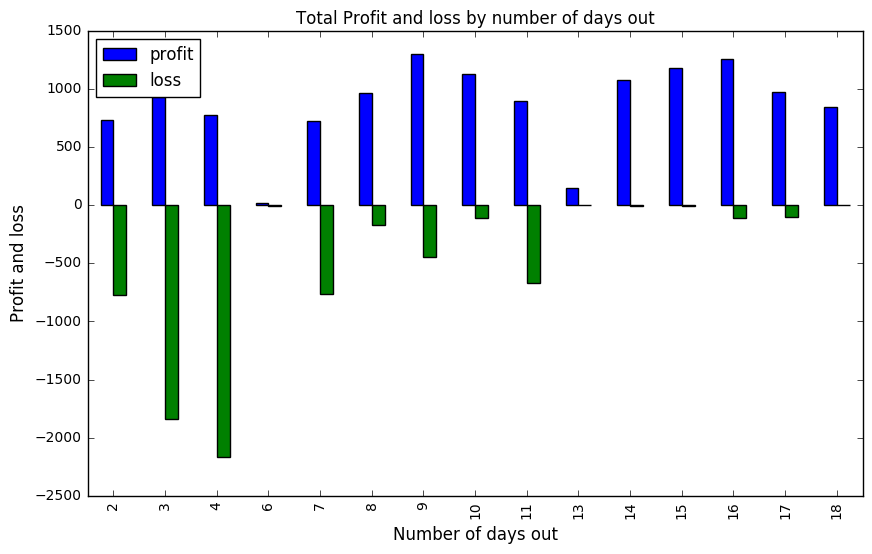

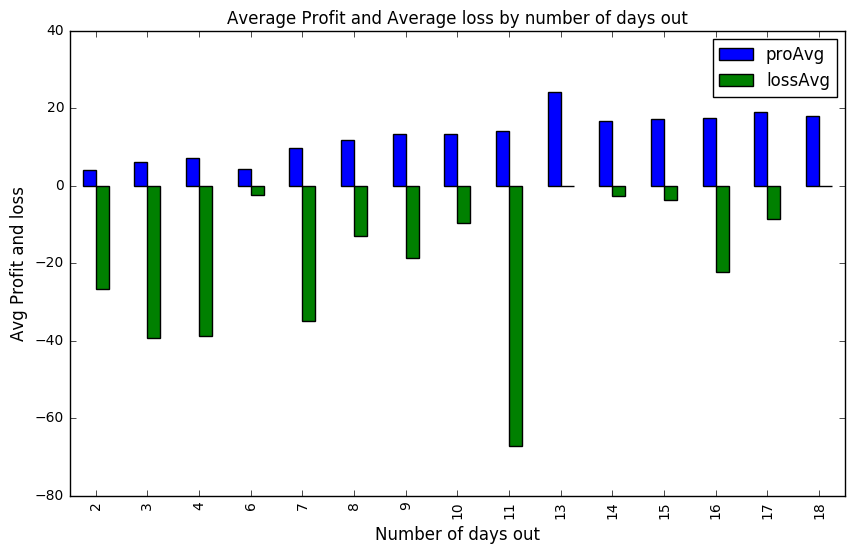

In [30]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

In [ ]:
## Third Strategy

In [31]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 1:
        if row.optionstrike < row.today_sp_price + row.optionclosingprice and row.optiontype == 0:
            if row.settle_sp_price >= row.optionstrike:
                #print row.optionclosingprice
                return row.optionclosingprice*multiplier
            else:
                #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
    elif row.pred == 0:
        if row.optionstrike >= row.today_sp_price - row.optionclosingprice  and row.optiontype == 1:
            if row.settle_sp_price <= row.optionstrike:
                #print row.optionclosingprice
                return row.optionclosingprice*multiplier
            else:
                #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
    else:
        return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)
interestedDf3 = testdf
interestedDf3 = testdf[testdf.pl!=0]

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
positivedf3 = interestedDf3
positivedf3 = interestedDf3[interestedDf3.pl > 0]
negativedf3 = interestedDf3
negativedf3 = interestedDf3[interestedDf3.pl < 0]

In [35]:
negativedf3.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,4.650000e+02
mean,6.434409,2073.574667,2033.799376,0.135484,2072.806452,16.001172,19962.049462,2071.515484,2076.775140,1.086797,1.087575,1.034430,1.171412,0.135484,13.398022,0.864516,-3.058341e+01
std,4.592969,75.869562,83.451052,0.342608,76.398070,8.865008,21272.389385,79.106947,73.389639,0.212271,0.874464,0.134104,0.814049,0.342608,8.415054,0.342608,3.097849e+01
min,2.000000,1890.280000,1880.020000,0.000000,1895.000000,0.875000,5002.000000,1893.360000,1851.860000,0.626649,0.060109,0.708325,0.222222,0.000000,0.000000,0.000000,-1.311600e+02
25%,3.000000,2019.640000,1970.890000,0.000000,2025.000000,8.550000,6854.000000,2017.460000,2016.710000,0.996264,0.555249,0.993385,0.678014,0.000000,6.060000,1.000000,-4.248000e+01
50%,4.000000,2079.610000,2023.040000,0.000000,2075.000000,15.250000,10674.000000,2089.140000,2086.590000,1.008535,0.889610,1.000000,1.000000,0.000000,12.670000,1.000000,-2.098000e+01
75%,9.000000,2112.130000,2081.180000,0.000000,2110.000000,22.650000,23417.000000,2112.130000,2109.660000,1.126619,1.101449,1.039731,1.426593,0.000000,20.380000,1.000000,-8.720000e+00
max,18.000000,2271.720000,2263.690000,1.000000,2275.000000,41.250000,132806.000000,2275.320000,2270.760000,2.291132,5.870968,2.107455,6.166667,1.000000,29.760000,1.000000,-4.263256e-14


In [36]:
positivedf3.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.614277,2076.056269,2098.845820,0.017847,2070.181347,16.871082,23323.970063,2074.762631,2071.472608,1.116485,1.027880,1.040963,1.037968,0.017847,15.056857,0.982153,14.915222
std,5.240394,87.684424,87.099372,0.132433,86.258366,10.904904,25267.631216,88.476284,94.542258,0.275240,0.912152,0.122991,0.699319,0.132433,8.815020,0.132433,10.196411
min,2.000000,1851.860000,1880.330000,0.000000,1825.000000,0.425000,5005.000000,1852.210000,1851.860000,0.499007,0.021718,0.499007,0.087121,0.000000,0.000000,0.000000,0.040000
25%,3.000000,2017.460000,2049.580000,0.000000,2015.000000,7.900000,8241.000000,2015.930000,1994.990000,1.000000,0.480132,0.998956,0.675000,0.000000,7.420000,1.000000,6.500000
50%,8.000000,2079.430000,2091.690000,0.000000,2075.000000,15.100000,14789.000000,2079.430000,2085.510000,1.026755,0.857143,1.003465,0.917782,0.000000,15.150000,1.000000,13.000000
75%,14.000000,2108.480000,2126.640000,0.000000,2110.000000,23.750000,26482.000000,2108.950000,2114.070000,1.136859,1.099057,1.047488,1.135417,0.000000,22.580000,1.000000,21.050000
max,18.000000,2328.250000,2347.220000,1.000000,2350.000000,56.200000,175350.000000,2316.100000,2298.370000,4.714684,7.000000,2.281036,7.000000,1.000000,30.000000,1.000000,55.850000


In [34]:
def plSummary(df):
    positivedf = df
    neagtivedf = df
    positivedf = df[df.pl > 0]
    negativedf = df[df.pl < 0]
    print "profit is "+ str(positivedf['pl'].sum())
    print "loss is " + str(negativedf['pl'].sum())

    
interestedDf3.describe()
plSummary(interestedDf3)

profit is 25907.74
loss is -14221.285


### plot histogram for total profit and loss based on each other numbers day out 

In [39]:
### create new data frame numbers of days out, total profit, total loss

def genPositiveDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','profit','proCount','proAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'profit':  group.pl.sum(),
     'proCount': group.pl.count(),
      'proAvg': group.pl.sum() / group.pl.count()
      }, ignore_index=True)
    return temp

def genNegativeDataframe(df):
    groups = df.groupby('daystosettle') 
    temp = pd.DataFrame(columns=['numofdays','loss','lossCount','lossAvg'])
    for name, group in groups:
        temp = temp.append({'numofdays': name,
     'loss':  group.pl.sum(),
     'lossCount': group.pl.count(),
     'lossAvg': group.pl.sum() / group.pl.count()                      
      }, ignore_index=True)
    return temp

pos3 = genPositiveDataframe(positivedf3)
neg3 = genNegativeDataframe(negativedf3)
plotdf3 = pos3.join(neg3.set_index('numofdays'), on='numofdays', how = 'outer')
plotdf3['loss'].fillna(0, inplace=True)
plotdf3['lossCount'].fillna(1, inplace=True)
plotdf3['lossAvg'].fillna(0, inplace=True)
plotdf3.numofdays = plotdf3.numofdays.astype(int)
plotdf3.set_index('numofdays', inplace=True)

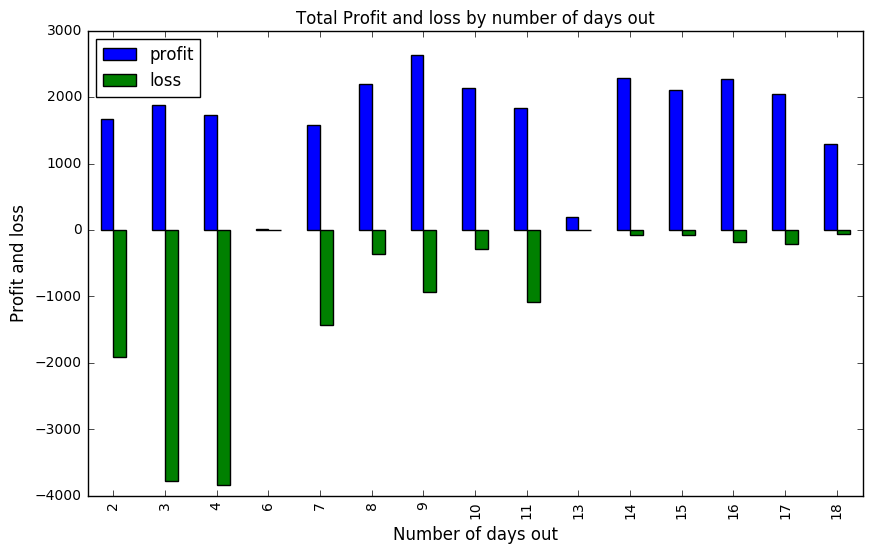

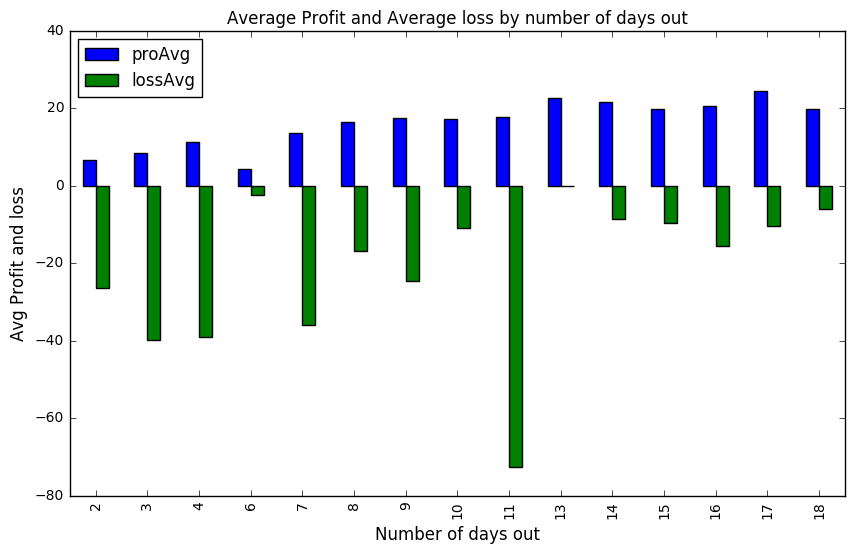

In [40]:
## plot "Total Profit and Total Loss by Number of Days Out"
ax = plotdf3[['profit','loss']].plot(kind='bar', title ="Total Profit and loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Profit and loss", fontsize=12)
plt.show()
## plot "Average Profit and Average Loss by Number of Days Out"
ax = plotdf3[['proAvg','lossAvg']].plot(kind='bar', title ="Average Profit and Average loss by number of days out", figsize=(10, 6), legend=True, fontsize=10)
ax.set_xlabel("Number of days out", fontsize=12)
ax.set_ylabel("Avg Profit and loss", fontsize=12)
plt.show()

### calculate sharpe ratio based on days to settle date and plot P&l distribution based on days to settle date

In [43]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row.daystosettle not in dayList:
        dayList.append(row.daystosettle)

def getDayDiff(df):
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(interestedDf3)

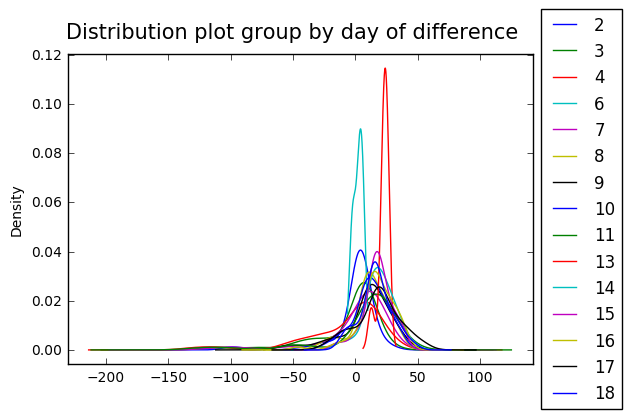

In [44]:
## draw pl distribution for each number of days 
def plotDistribution(df):
    groups = df.groupby('daystosettle')
    fig, ax = plt.subplots()
    fig.suptitle('Distribution plot group by day of difference', fontsize=15)
    ax.margins(0.05) 
    
    for name, group in groups:
        group.pl.plot(kind='kde', label=name)
        ##ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plotDistribution(interestedDf3)
plt.show()

In [45]:
def computeSharpeRatio(df):
    return df['pl'].mean() / df['pl'].std()

def getSharpeRatio(df):
    groups = df.groupby('daystosettle')
    res = []
    for name, group in groups:
        tmp = computeSharpeRatio(group)
        res.append((name, tmp))
    return res

SharpeList = getSharpeRatio(interestedDf3)
print SharpeList

[(2, -0.034530342789478481), (3, -0.21078056140115703), (4, -0.25328565552490429), (6, 0.56744091514501593), (7, 0.033043166832276753), (8, 0.80561476891834982), (9, 0.43780964282761092), (10, 0.85984703263269713), (11, 0.18801697294641564), (13, 5.611222538009363), (14, 1.5586299431497048), (15, 1.5182579956889422), (16, 1.1390130276288324), (17, 0.98558109832471874), (18, 1.2831887510828328)]
